# SHAP Values for XGB With All Age Data

In [1]:
%pwd

'/mnt/d/OneDrive - Kyushu University/ESG09_Article/Code'

In [2]:
%cd ..

/mnt/d/OneDrive - Kyushu University/ESG09_Article


/home/linux/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Package

In [3]:
import matplotlib.pyplot as plt
from joblib import dump, load
import os 
import pandas as pd
#import shap
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [4]:
xgb.__version__

'2.0.3'

In [5]:
from cuml.explainer import KernelExplainer

/home/linux/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "/home/linux/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/numba/cuda/cudadrv/driver.py", line 254, in ensure_initialized
    self.cuInit(0)
  File "/home/linux/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/numba/cuda/cudadrv/driver.py", line 327, in safe_cuda_api_call
    self._check_ctypes_error(fname, retcode)
  File "/home/linux/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/numba/cuda/cudadrv/driver.py", line 395, in _check_ctypes_error
    raise CudaAPIError(retcode, msg)
numba.cuda.cudadrv.driver.CudaAPIError: [100] Call to cuInit results in CUDA_ERROR_NO_DEVICE

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/home/linux/anaconda3

In [ ]:
import cudf

## SHAP 

### load data and hyperparameter

In [9]:
dict(bayes_search.best_params_)

{'gamma': 0.001035679916752757,
 'learning_rate': 0.030918808165467035,
 'max_delta_step': 0.3824267566556339,
 'max_depth': 11,
 'min_child_weight': 0.16747411396464854,
 'n_estimators': 2441,
 'reg_alpha': 1.1240879648711004,
 'reg_lambda': 0.006725578387643221,
 'subsample': 0.653416651975892}

In [8]:
hyper_dict = {'gamma': 0.001035679916752757,
 'learning_rate': 0.030918808165467035,
 'max_delta_step': 0.3824267566556339,
 'max_depth': 11,
 'min_child_weight': 0.16747411396464854,
 'n_estimators': 2441,
 'reg_alpha': 1.1240879648711004,
 'reg_lambda': 0.006725578387643221,
 'subsample': 0.653416651975892}

In [9]:
Df_Filename = os.path.join("Data", "GallupWB_Ml64var1911k14wave_v1.parquet")

In [10]:
Df = pd.read_parquet(Df_Filename)

In [11]:
#Df['COUNTRY_ISO3'] = Df['COUNTRY_ISO3'].astype('category')
label_encoder = LabelEncoder()
Df['COUNTRY_ISO3'] = label_encoder.fit_transform(Df['COUNTRY_ISO3'])

In [12]:
Df['COUNTRY_ISO3'].describe()

count    1.911212e+06
mean     7.819511e+01
std      4.666500e+01
min      0.000000e+00
25%      3.800000e+01
50%      7.400000e+01
75%      1.180000e+02
max      1.630000e+02
Name: COUNTRY_ISO3, dtype: float64

In [13]:
Df = Df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
ytot = Df['Cantril_ladder']

In [15]:
Xtot = Df.drop(columns=['Cantril_ladder'])

### Shap Computation

In [16]:
reg_xgb = xgb.XGBRegressor(objective='reg:squarederror',  device = 'cuda', tree_method='hist', random_state=42, enable_categorical=True, **hyper_dict)

In [17]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

In [16]:
### xgb 1.5.2
scores = []
for train_index, test_index in kf.split(Xtot):
    X_train, X_test = Xtot.iloc[train_index, :], Xtot.iloc[test_index, :]
    y_train, y_test = ytot.iloc[train_index], ytot.iloc[test_index]
    
    # Train the model
    model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='gpu_hist', random_state=42, 
                              predictor='gpu_predictor', **hyper_dict)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"r2 is {r2}")
    scores.append(r2)

r2 is 0.37775169807470577


KeyboardInterrupt: 

In [18]:
for train_index, test_index in kf.split(Xtot):
    X_train, X_test = Xtot.iloc[train_index, :], Xtot.iloc[test_index, :]
    y_train, y_test = ytot.iloc[train_index], ytot.iloc[test_index]
    break

In [20]:
cX_train = cudf.from_pandas(X_train)
cX_test = cudf.from_pandas(X_test)
cy_train = cudf.from_pandas(y_train)
cy_test = cudf.from_pandas(y_test)

In [21]:
model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', random_state=42, device = 'cuda')
model.fit(cX_train, cy_train)

/home/linux/anaconda3/envs/rapids-24.06/lib/python3.11/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [24]:
cu_explainer = KernelExplainer(model=model.predict,
                               data=cX_train,
                               is_gpu_model=True, random_state=1)

CudaSupportError: Error at driver init: Call to cuInit results in CUDA_ERROR_NO_DEVICE (100)

In [ ]:
cu_shap_value_merge = cu_explainer.shap_values(X_test.iloc[(kID-1)*100:kID*100,:])

In [19]:
explainer = shap.explainers.GPUTree(model, X_test.iloc[:100,:])
shap_values = explainer(X_test)

[16:31:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[16:31:51] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


cuda extension was not built during install!


ImportError: cannot import name '_cext_gpu' from partially initialized module 'shap' (most likely due to a circular import) (/home/linux/.local/lib/python3.9/site-packages/shap-0.41.0-py3.9-linux-x86_64.egg/shap/__init__.py)

In [16]:
scores = []
for train_index, test_index in kf.split(Xtot):
    X_train, X_test = Xtot.iloc[train_index, :], Xtot.iloc[test_index, :]
    y_train, y_test = ytot.iloc[train_index], ytot.iloc[test_index]
    
    # Train the model
    model = xgb.XGBRegressor(objective='reg:squarederror',  device = 'cuda', tree_method='hist', random_state=42, enable_categorical=True, **bayes_search.best_params_)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"r2 is {r2}")
    scores.append(r2)

[12:18:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



r2 is 0.37817792912933634
r2 is 0.3775104740910571
r2 is 0.37507826476202055
r2 is 0.37495233437810227
r2 is 0.3786538185860009
r2 is 0.3776146919855152
r2 is 0.3771879596295743
r2 is 0.3761106066976906
r2 is 0.3787833662988842
r2 is 0.3766568007094363


In [17]:
scores

[0.37817792912933634,
 0.3775104740910571,
 0.37507826476202055,
 0.37495233437810227,
 0.3786538185860009,
 0.3776146919855152,
 0.3771879596295743,
 0.3761106066976906,
 0.3787833662988842,
 0.3766568007094363]

In [20]:
Shap_df = []

i = 1
for train_index, test_index in kf.split(Xtot):
    print(f"This is {i} fold")
    X_train, X_test = Xtot.iloc[train_index, :], Xtot.iloc[test_index, :]
    y_train, y_test = ytot.iloc[train_index], ytot.iloc[test_index]
    print(X_test.iloc[:100,:].shape)
    
    # Train the model
    model = xgb.XGBRegressor(objective='reg:squarederror',  predictor = 'gpu_predictor', 
                             tree_method='gpu_hist', random_state=42, **hyper_dict)
    #model = xgb.XGBRegressor(objective='reg:squarederror',  n_jobs = -1, random_state=42, enable_categorical=True, **bayes_search.best_params_)
    model.fit(X_train, y_train)
    
    print('model doen')
    explainer = shap.KernelExplainer(model, data = X_test.iloc[:100,:])
    shap_values = explainer.shap_values(X_test)
    break

    colnames = X_test.columns + '_shap'
    X_test_shap= pd.DataFrame(shap_values, columns=colnames, index=X_test.index).head()
    X_test_merge = pd.concat([y_test, X_test, X_test_shap], axis=1)

    Shap_df.append(X_test_merge)

    i = i + 1
    break
    #dump(Shap_df, "Results/Shap_TotalDataset.joblib")

This is 1 fold
(100, 63)
model doen
Provided model function fails when applied to the provided data set.


TypeError: 'XGBRegressor' object is not callable

In [ ]:
    explainer = shap.Explainer(model, X_train, algorithm="tree")
    shap_values = explainer(X_test)

  0%|                   | 237/191122 [02:14<1798:46]       

In [19]:
Concat_Shap = pd.concat(Shap_df, axis=0)

In [20]:
Concat_Shap.shape

(1911212, 127)

In [22]:
Concat_Shap.columns

Index(['Cantril_ladder', 'wave', 'INCOME_2', 'Health_disable', 'Relative_have',
       'Living_standard_change', 'Enough_food', 'Enough_shelter',
       'Well_rested', 'Respected',
       ...
       'Corruption_government_shap', 'Performance_leadership_shap',
       'Gender_female_shap', 'Age_shap', 'Marital_status_shap',
       'Employment_shap', 'Children_under15_shap', 'Feeling_income_shap',
       'Income_level_shap', 'COUNTRY_ISO3_shap'],
      dtype='object', length=127)

### Draw Plot of Age

In [4]:
Shap_df = load("Results/Shap_TotalDataset.joblib")

In [5]:
Concat_Shap = pd.concat(Shap_df, axis=0)

In [7]:
Concat_Shap.shape

(1911212, 127)

In [12]:
#Concat_Shap.to_parquet("Results/Shap_TotalDatasetTreeEplain.parquet")

In [11]:
sorted(Concat_Shap['Age_shap'].unique())

[-0.124694675,
 -0.115843564,
 -0.10764524,
 -0.096717134,
 -0.0953448,
 -0.09152395,
 -0.07808477,
 -0.07709958,
 -0.07202862,
 -0.06983307,
 -0.068805225,
 -0.06774917,
 -0.066160336,
 -0.06567106,
 -0.06270729,
 -0.049408544,
 -0.04351601,
 -0.042899374,
 -0.0401199,
 -0.03655449,
 -0.026123503,
 -0.0040100887,
 0.0035142554,
 0.0035751336,
 0.0152991,
 0.015776563,
 0.016043244,
 0.01662778,
 0.023073712,
 0.02431558,
 0.025328545,
 0.028254567,
 0.030908678,
 0.036854308,
 0.038859017,
 0.06491261,
 0.06526296,
 0.06938681,
 0.08033723,
 0.08868406,
 0.08889696,
 0.0918609,
 0.11063762,
 0.11184761,
 0.11351052,
 0.17558543,
 nan,
 0.11346496,
 0.1377993,
 0.1970437,
 0.3454863]

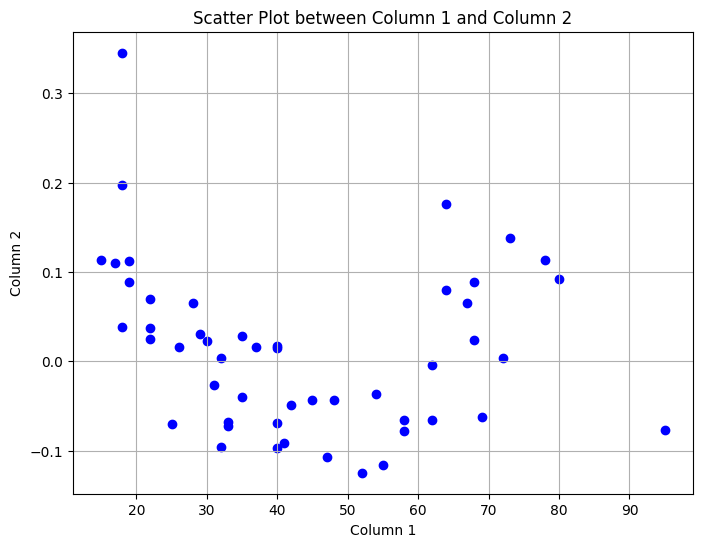

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(Concat_Shap['Age'], Concat_Shap['Age_shap'], color='blue')
plt.title('Scatter Plot between Column 1 and Column 2')
plt.xlabel('Column 1')
plt.ylabel('Column 2')
plt.grid(True)
plt.show()